<a href="https://colab.research.google.com/github/joseph-cheung/From-DnCNN-to-UDnCNN-and-DUDnCNN/blob/main/DnCNN_UDnCNN_DUDnCNN_with_LeakyReLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DnCNN UDnCNN DUDnCNN with LeakyReLU


## 1. 下载数据集

In [1]:
!wget -N https://raw.githubusercontent.com/eebowen/Transfer-Learning-and-Deep-Neural-Network-Acceleration-for-Image-Classification/master/nntools.py
!wget -N https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
!tar -zxvf BSDS300-images.tgz
dataset_root_dir = './BSDS300/images/'

--2021-06-17 12:44:18--  https://raw.githubusercontent.com/eebowen/Transfer-Learning-and-Deep-Neural-Network-Acceleration-for-Image-Classification/master/nntools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12781 (12K) [text/plain]
Saving to: ‘nntools.py’

nntools.py          100%[===================>]  12.48K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-06-17 12:44:18 (92.6 MB/s) - ‘nntools.py’ saved [12781/12781]

--2021-06-17 12:44:18--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, a

In [2]:
%matplotlib inline

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import time

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## 2. 训练集加噪

$σ = 30$ 高斯噪音 $180 × 180$ 裁剪（左上角或随机位置）

In [4]:
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')   
        # 随机裁剪
        #i = np.random.randint(clean.size[0] - self.image_size[0])
        #j = np.random.randint(clean.size[1] - self.image_size[1])
        i=0
        j=0
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            # 转换张量
            tv.transforms.ToTensor(),
            # [−1, 1]
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

#### 导训练集和测试集进来

In [6]:
train_set = NoisyBSDSDataset(dataset_root_dir)
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320))

image size is torch.Size([3, 320, 320]).


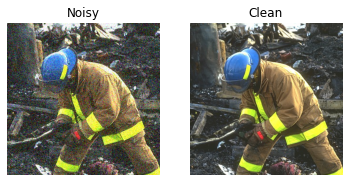

In [7]:
x = test_set[0]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')

## 3. DnCNN

#### loss 用的均方差

In [13]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

### CNN 网络为啥要带个权重

看这个台湾人写的比较清楚
[深度學習: Weight initialization和Batch Normalization](https://chih-sheng-huang821.medium.com/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-weight-initialization%E5%92%8Cbatch-normalization-f264c4be37f5)

#### 无权初始化

In [14]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

零填充（泛卷积）对输入图像矩阵的边缘进行滤波，是玄学

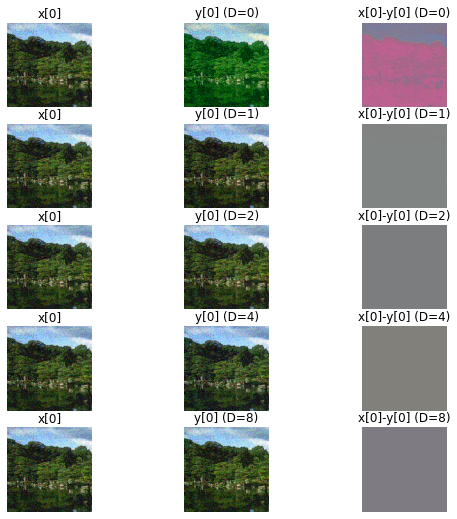

In [15]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x) # 4-d
    # 3-d
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

D=0 才有残差输出，梯度消失，没法炼丹

#### 带权跑一下

In [16]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # Batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.leaky_relu(self.conv[0](x))
        for i in range(D):
            h = F.leaky_relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

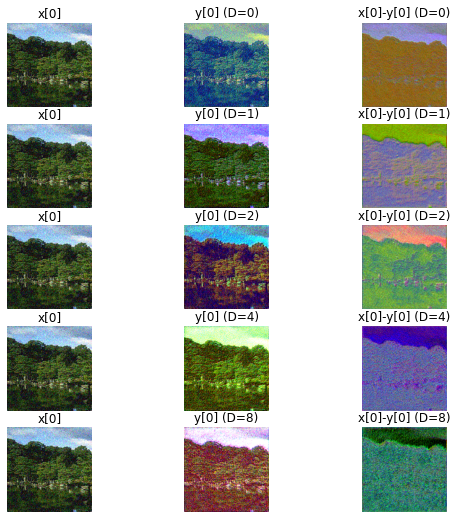

In [17]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)
    
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

然后残差就非零，能梯度下降，能炼丹

### PSNR

峰值信噪比 PSNR (Peak Signal-to-Noise-Ratio)，值域是 `[−1, 1]` 
$$
PSNR = 10\log_{10}\frac{4n}{\Vert y-d\Vert_2^2}
$$

`d` 是理想值， `y` 是估计值，分母就是均方差， `n` 是张量大小，对数定义，单位是 `dB`，数越大越好

#### 这东西是要算平均的

In [18]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [19]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

### `DnCNN` 炼丹

In [20]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="./checkpoints/denoising1", perform_validation_during_training=True)

Start/Continue training from epoch 200
Finish training for 200 epochs


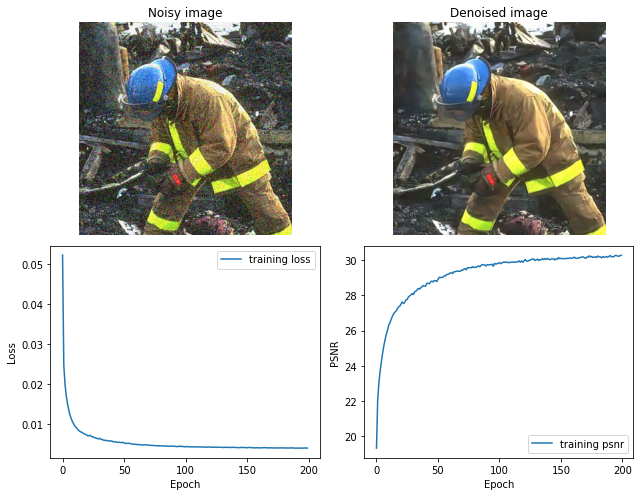

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[0][0]))

### 效果

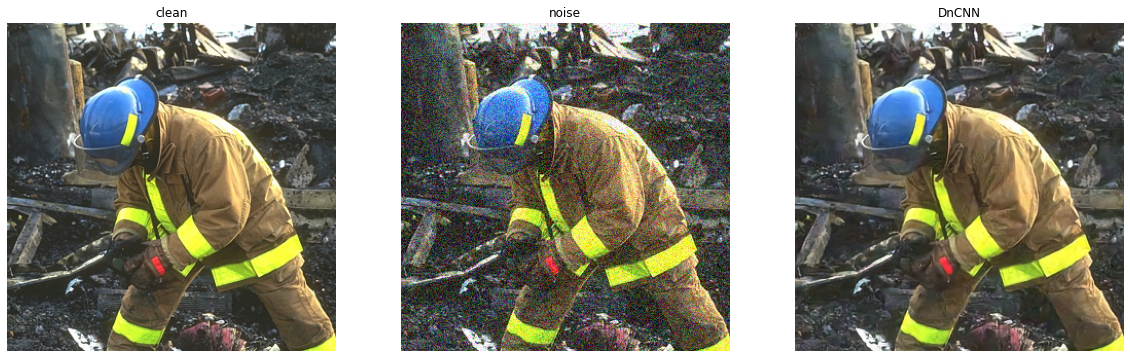

In [22]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'DnCNN']

x, clean = test_set[0]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(20,10), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

仍存在噪点，有信息缺失

### `DnCNN` 网络参数

In [23]:
for name, param in model.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

参数个数

第一层有 `64 x 3 x 3 x 3` 个 parameter. `D` 层则有 `64 x 64 x 3 x 3 x D`. 最后一层是 `3 x 64 x 3 x 3` . 总共 `3456 + 36864 x D`

感受野 (Receptive Field) 计算：

没有池化层，每层固定增加 $2^{0-0+1}=2$，初始输入层是 1 ，小学奥数得到 $R_D=(1+2\times (D+2))^2$. 

`D=6` 为例， $R_6=17^2$.

据说（待考证）σ = 30 高斯噪声下的降噪，单个像素应受到 33 × 33 个像素影响，据此来确定深度。

感受野 $R_D=(1+2\times (D+2)) \times (1+2\times (D+2))$， 令等于33 得到 $D=14$，参数个数 $3456 + 36864 \times 14 = 519552$。

## 4. UDnCNN
U-net like CNNs

In [24]:
class UDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
    # 前面都一样，这里搞个U-Net
    def forward(self, x):
        D = self.D
        h = F.leaky_relu(self.conv[0](x))
        h_buff = []
        idx_buff = []
        shape_buff = []
        for i in range(D//2-1):
            shape_buff.append(h.shape)
            h, idx = F.max_pool2d(F.leaky_relu(self.bn[i](self.conv[i+1](h))), 
                                  kernel_size=(2,2), return_indices=True)
            h_buff.append(h)
            idx_buff.append(idx)
        for i in range(D//2-1, D//2+1):
            h = F.leaky_relu(self.bn[i](self.conv[i+1](h)))
        for i in range(D//2+1, D):
            j = i - (D//2 + 1) + 1
            h = F.max_unpool2d(F.leaky_relu(self.bn[i](self.conv[i+1]((h+h_buff[-j])/np.sqrt(2)))), 
                               idx_buff[-j], kernel_size=(2,2), output_size=shape_buff[-j])
        y = self.conv[D+1](h) + x
        return y

### `UDnCNN` 炼丹

In [25]:
lr = 1e-3
net = UDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp2 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="/content/checkpoints/denoising2", perform_validation_during_training=True)

Start/Continue training from epoch 50
Epoch 51 (Time: 3.56s)
Epoch 52 (Time: 3.37s)
Epoch 53 (Time: 3.42s)
Epoch 54 (Time: 3.36s)
Epoch 55 (Time: 3.37s)
Epoch 56 (Time: 3.35s)
Epoch 57 (Time: 3.36s)
Epoch 58 (Time: 3.38s)
Epoch 59 (Time: 3.35s)
Epoch 60 (Time: 3.34s)
Epoch 61 (Time: 3.36s)
Epoch 62 (Time: 3.41s)
Epoch 63 (Time: 3.39s)
Epoch 64 (Time: 3.35s)
Epoch 65 (Time: 3.35s)
Epoch 66 (Time: 3.37s)
Epoch 67 (Time: 3.36s)
Epoch 68 (Time: 3.36s)
Epoch 69 (Time: 3.37s)
Epoch 70 (Time: 3.37s)
Epoch 71 (Time: 3.39s)
Epoch 72 (Time: 3.39s)
Epoch 73 (Time: 3.38s)
Epoch 74 (Time: 3.36s)
Epoch 75 (Time: 3.38s)
Epoch 76 (Time: 3.36s)
Epoch 77 (Time: 3.34s)
Epoch 78 (Time: 3.36s)
Epoch 79 (Time: 3.36s)
Epoch 80 (Time: 3.36s)
Epoch 81 (Time: 3.40s)
Epoch 82 (Time: 3.36s)
Epoch 83 (Time: 3.38s)
Epoch 84 (Time: 3.37s)
Epoch 85 (Time: 3.36s)
Epoch 86 (Time: 3.38s)
Epoch 87 (Time: 3.39s)
Epoch 88 (Time: 3.38s)
Epoch 89 (Time: 3.38s)
Epoch 90 (Time: 3.36s)
Epoch 91 (Time: 3.38s)
Epoch 92 (Time: 3.3

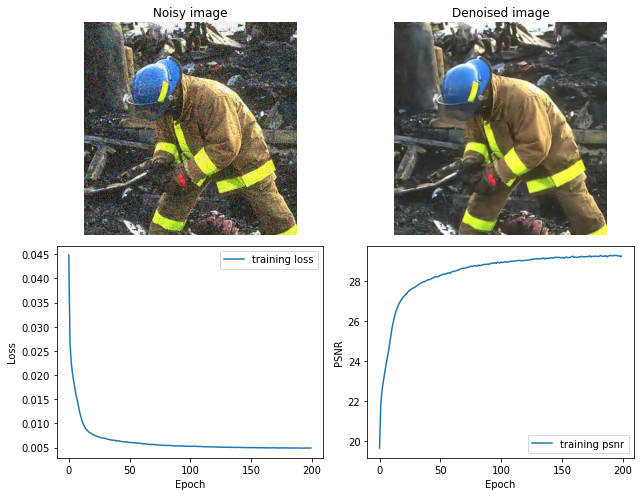

In [26]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[0][0]))

### `UDnCNN` 网络参数

In [31]:
for name, param in exp2.net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

池化不改变参数个数，还是 `3456 + 36864 x D`.

感受野 (Receptive Field) 计算：

$R_D=(1+\sum_{i=1}^{D/2}2^i+2\times 2^{D/2}+\sum_{i=1}^{D/2-1}2^i+2)^2$.

`D=6` 为例 $R_6(1+(2+4+8)+(2\times 8)+(4+2)+2)^2=39^2$.

从 PSNR 看，加了 U-Net 更烂了... 池化会丢失价值特征信息，但图上看起来更“好看”了...

### 比比 `DnCNN` 和 `UDnCNN`

In [32]:
# DnCNN
exp1.evaluate()

{'PSNR': tensor(29.0894), 'loss': 0.005089376987889409}

In [33]:
# UDnCNN
exp2.evaluate()

{'PSNR': tensor(28.3012), 'loss': 0.0060464405920356516}

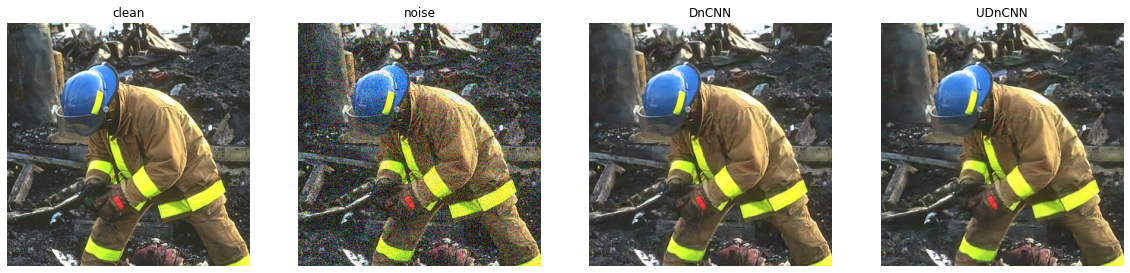

In [34]:
img = []
titles = ['clean', 'noise', 'DnCNN','UDnCNN']

x, clean = test_set[0]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model = exp1.net.to(device)
model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])

model = exp2.net.to(device)
model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=4, figsize=(20,10), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

## 5. DUDnCNN
U-net like CNNs with dilated convolutions

空洞卷积(dilated convolution)代替池化来增大感受野(Receptive Field)

然而 pytorch 空洞卷积跑的贼慢，原理上看应该和普通卷积差不多快，这里有个优化的问题...

空洞卷积之前
`torch.backends.cudnn.benchmark=True` 之后改回 `torch.backends.cudnn.benchmark=False` 可以提速，详见 [https://github.com/pytorch/pytorch/issues/15054](https://github.com/pytorch/pytorch/issues/15054).

In [35]:
class DUDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # 空洞卷积
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # 卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.leaky_relu(self.conv[0](x))
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            h_buff.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            
        y = self.conv[D+1](h) + x
        return y

### `DUDnCNN` 炼丹

In [37]:
lr = 1e-3
net = DUDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="./checkpoints/denoising3", perform_validation_during_training=True)

In [38]:
exp3

Net(DUDnCNN(
  (mse): MSELoss()
  (conv): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn): ModuleList(
    (0): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True

Start/Continue training from epoch 50
Epoch 51 (Time: 6.67s)
Epoch 52 (Time: 6.41s)
Epoch 53 (Time: 6.42s)
Epoch 54 (Time: 6.46s)
Epoch 55 (Time: 6.48s)
Epoch 56 (Time: 6.48s)
Epoch 57 (Time: 6.56s)
Epoch 58 (Time: 6.58s)
Epoch 59 (Time: 6.56s)
Epoch 60 (Time: 6.60s)
Epoch 61 (Time: 6.59s)
Epoch 62 (Time: 6.62s)
Epoch 63 (Time: 6.56s)
Epoch 64 (Time: 6.57s)
Epoch 65 (Time: 6.55s)
Epoch 66 (Time: 6.57s)
Epoch 67 (Time: 6.58s)
Epoch 68 (Time: 6.58s)
Epoch 69 (Time: 6.58s)
Epoch 70 (Time: 6.60s)
Epoch 71 (Time: 6.60s)
Epoch 72 (Time: 6.61s)
Epoch 73 (Time: 6.64s)
Epoch 74 (Time: 6.64s)
Epoch 75 (Time: 6.62s)
Epoch 76 (Time: 6.65s)
Epoch 77 (Time: 6.65s)
Epoch 78 (Time: 6.64s)
Epoch 79 (Time: 6.65s)
Epoch 80 (Time: 6.64s)
Epoch 81 (Time: 6.67s)
Epoch 82 (Time: 6.66s)
Epoch 83 (Time: 6.64s)
Epoch 84 (Time: 6.66s)
Epoch 85 (Time: 6.66s)
Epoch 86 (Time: 6.65s)
Epoch 87 (Time: 6.65s)
Epoch 88 (Time: 6.67s)
Epoch 89 (Time: 6.70s)
Epoch 90 (Time: 6.68s)
Epoch 91 (Time: 6.70s)
Epoch 92 (Time: 6.7

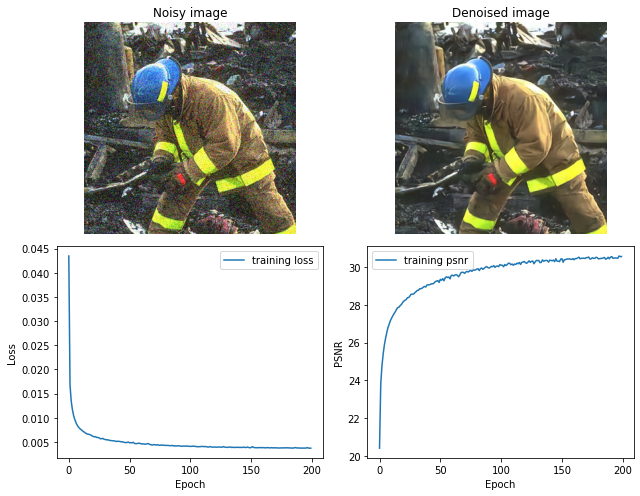

In [39]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[0][0]))

### 比较 `DnCNN` `UDnCNN` `DUDnCNN`

In [40]:
# DnCNN
exp1.evaluate()

{'PSNR': tensor(29.0859), 'loss': 0.00509307918138802}

In [41]:
# UDnCNN
exp2.evaluate()

{'PSNR': tensor(28.3015), 'loss': 0.0060443114023655655}

In [42]:
# DUDnCNN
exp3.evaluate()

{'PSNR': tensor(29.1659), 'loss': 0.005009378213435412}

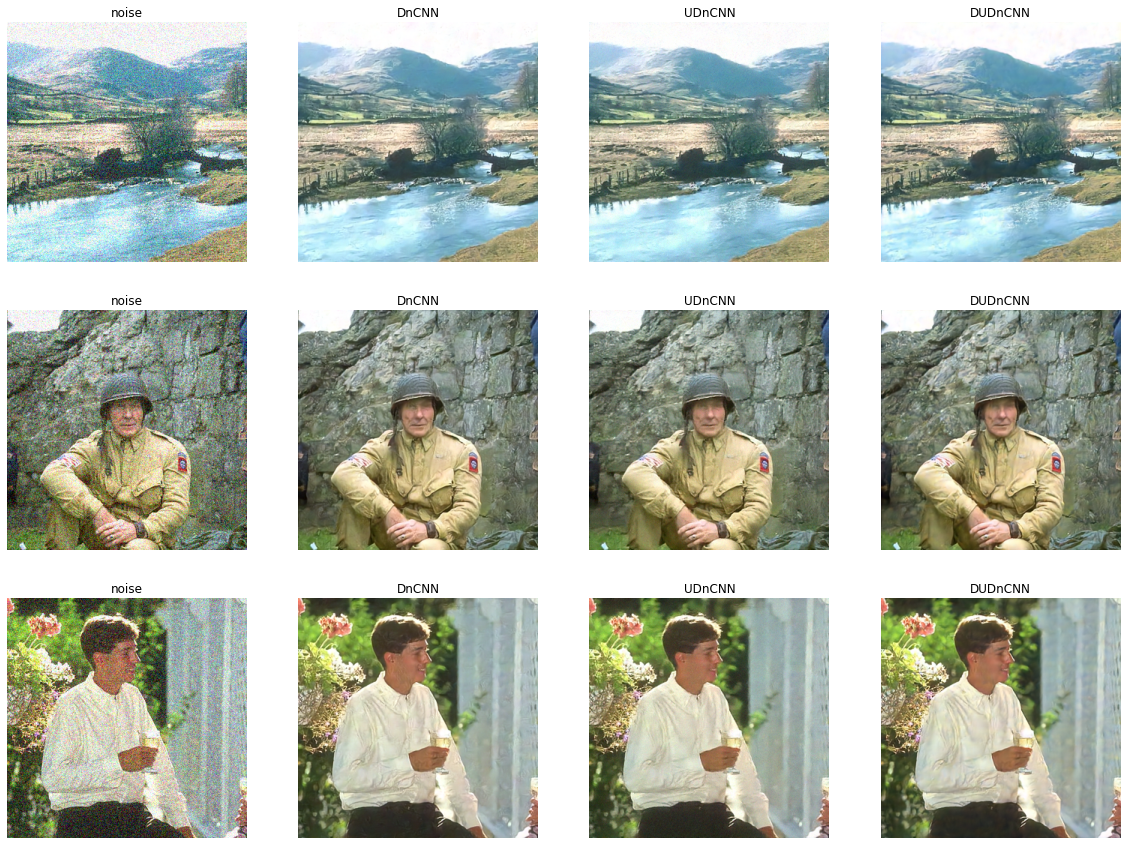

In [43]:
num = 3
img = []
nets = [exp1.net, exp2.net, exp3.net]
titles = ['noise','DnCNN', 'UDnCNN', 'DUDnCNN']

fig, axes = plt.subplots(nrows=num, ncols=4, figsize=(20,15), sharex='all', sharey='all')

for i in range(num):
    myimshow(test_set[7*i+7][0], ax=axes[i][0])
    x, _ = test_set[7*i+7]
    x = x.unsqueeze(0).to(device)
    img.append(x)

for i in range(num):
    for j in range(len(nets)):
        
        model = nets[j].to(device)
        model.eval()
        with torch.no_grad():
            y = model.forward(img[i])
        myimshow(y[0], ax=axes[i][j+1])
for i in range(num):
    for j in range(len(titles)):
        axes[i][j].set_title(f'{titles[j]}')

### `DUDnCNN` 网络参数

In [44]:
exp3.net

DUDnCNN(
  (mse): MSELoss()
  (conv): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn): ModuleList(
    (0): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
  

In [45]:
for name, param in exp3.net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

参数个数还是不变 `3456 + 36864 x D`

感受野 (Receptive Field) 计算： 

$R_D=(1+2+\sum_{i=1}^{D/2}2^i\times 2^{i-1}+2^{D/2}\times 2^{D/2-1}+\sum_{i=1}^{D/2-1}2^i\times 2^{i-1}+2)^2$. 

$R_6=89^2$.